In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
using BenchmarkTools
using EzXML
ENV["COLUMNS"] = 130

130

In [2]:
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
traj_dir = "./sim_result"
ff_dir = "./sim_result"
njobs = 9

target_traj_path = "./sim_result/sim10/traj_10.dcd"
target_ff_filepath = "./sim_result/sim10/sim_10.xml"

"./sim_result/sim10/sim_10.xml"

In [3]:
slice = 1 # データのスライス
atom_pairs = [5 15] #距離を計算する原子のペア

1×2 Matrix{Int64}:
 5  15

In [4]:
phi_indices = [5, 7, 9, 15]   #二面角ϕのインデックス
psi_indices = [7, 9, 15, 17]  #二面角ψのインデックス

4-element Vector{Int64}:
  7
  9
 15
 17

In [5]:
top = readpdb(pdb_filepath)

#input target traj
ta = mdload(target_traj_path, top=top)
ta = ta[1:slice:end]
phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
dihedral_target = hcat(phi, psi)
distance_target = vec(compute_distance(ta, atom_pairs) ./ 10) # nmに変換

for i in 1:length(top.atomid)
    println("atomid = $(top.atomid[i]), atomname = $(top.atomname[i])")
end
println()
#sanity check
@show ta[:,vec(atom_pairs)].atomname
@show ta[:, phi_indices].atomname
@show ta[:, psi_indices].atomname

atomid = 1, atomname = HH31
atomid = 2, atomname = CH3
atomid = 3, atomname = HH32
atomid = 4, atomname = HH33
atomid = 5, atomname = C
atomid = 6, atomname = O
atomid = 7, atomname = N
atomid = 8, atomname = H
atomid = 9, atomname = CA
atomid = 10, atomname = HA
atomid = 11, atomname = CB
atomid = 12, atomname = HB1
atomid = 13, atomname = HB2
atomid = 14, atomname = HB3
atomid = 15, atomname = C
atomid = 16, atomname = O
atomid = 17, atomname = N
atomid = 18, atomname = H
atomid = 19, atomname = CH3
atomid = 20, atomname = HH31
atomid = 21, atomname = HH32
atomid = 22, atomname = HH33

(ta[:, vec(atom_pairs)]).atomname = ["C", "C"]
(ta[:, phi_indices]).atomname = ["C", "N", "CA", "C"]
(ta[:, psi_indices]).atomname = ["N", "CA", "C", "N"]


4-element Vector{String}:
 "N"
 "CA"
 "C"
 "N"

In [6]:
#input traj

dihedral_k = Array{Array{Float64}}(undef, njobs) # 二面角ϕ,ψの値
distance_k = Array{Array{Float64}}(undef, njobs) # 二つの原子間の距離

for i in 1:njobs
    traj_filepath = joinpath(traj_dir, "sim$(i)/traj_$(i).dcd")
    ta = mdload(traj_filepath, top=top)
    ta = ta[1:slice:end]

    phi = compute_dihedral(ta[:,phi_indices[1]], ta[:,phi_indices[2]], ta[:,phi_indices[3]], ta[:,phi_indices[4]]) * π / 180
    psi = compute_dihedral(ta[:,psi_indices[1]], ta[:,psi_indices[2]], ta[:,psi_indices[3]], ta[:,psi_indices[4]]) * π / 180
    dihedral_k[i] = hcat(phi, psi)
    
    distance = vec(compute_distance(ta, atom_pairs) ./ 10) # nmに変換
    distance_k[i] = distance
end

In [7]:
using Plots
bin_counts_k = []

# グリッドのサイズを設定
n_bins = 30
xedges = range(-π, stop=π, length=n_bins+1)
yedges = range(-π, stop=π, length=n_bins+1)

xcenters = [(xedges[i+1] + xedges[i]) / 2 for i in 1:n_bins]
ycenters = [(yedges[i+1] + yedges[i]) / 2 for i in 1:n_bins]
# 2次元ヒストグラムの計算
for kstate in 1:njobs
    
    # データの生成（大量のランダムデータを使用）
    n_points = size(dihedral_k[kstate], 1)
    #n_points = 10
    
    bin_counts = zeros(Float64, n_bins, n_bins)
    
    for i in 1:n_points
        x_bin = argmin(abs.(xcenters .- dihedral_k[kstate][i, 1])) - 1
        y_bin = argmin(abs.(ycenters .- dihedral_k[kstate][i, 2])) - 1
    
        if x_bin > 0 && x_bin <= n_bins && y_bin > 0 && y_bin <= n_bins
            bin_counts[y_bin, x_bin] += 1
        end
    end

    push!(bin_counts_k, bin_counts)
end

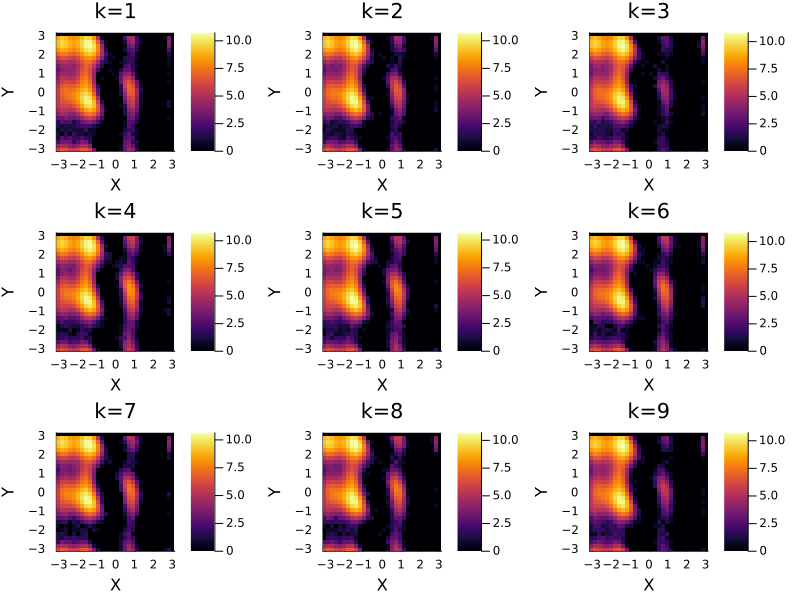

In [8]:
# ヒートマップのプロット
p = [heatmap(xcenters, ycenters, log.(bin_counts_k[k].+1), 
        colorscale="Viridis", xlabel="X", ylabel="Y", title="k=$(k)") for k in 1:njobs]

plot(p..., layout=(3, 3), size=(800, 600))

In [9]:
using Statistics
using Random
using Plots

# ヒストグラムの計算
function manual_histogram(data, num_bins)
    min_val, max_val = minimum(data), maximum(data)
    bin_width = (max_val - min_val) / num_bins
    bins = collect(min_val:bin_width:max_val)
    counts = zeros(num_bins)
    
    for d in data
        bin_index = min(floor(Int, (d - min_val) / bin_width) + 1, num_bins)
        counts[bin_index] += 1
    end
    
    return counts, bins
end

# ブートストラップ法による信頼区間の計算
function bootstrap_histogram_confidence_interval(data, num_bins, num_bootstrap=1000, confidence_level=0.95)
    n = length(data)
    counts, bins = manual_histogram(data, num_bins)
    bootstrap_counts = zeros(num_bootstrap, num_bins)

    for b in 1:num_bootstrap
        resample = [data[rand(1:n)] for _ in 1:n]
        bootstrap_counts[b, :], _ = manual_histogram(resample, num_bins)
    end

    lower_bound = mapslices(x -> quantile(x, (1 - confidence_level) / 2), bootstrap_counts; dims=1)[:]
    upper_bound = mapslices(x -> quantile(x, 1 - (1 - confidence_level) / 2), bootstrap_counts; dims=1)[:]

    return counts, bins, lower_bound, upper_bound
end

# 任意の一次元配列 data に対してヒストグラムを計算し、信頼区間を求める関数
function histogram_with_confidence_interval(data; num_bins=10, num_bootstrap=1000, confidence_level=0.95)
    counts, bins, lower_bound, upper_bound = bootstrap_histogram_confidence_interval(data, num_bins, num_bootstrap, confidence_level)

    # プロットのためのビンの中心を計算
    bin_centers = 0.5 .* (bins[1:end-1] .+ bins[2:end])

    return bin_centers, counts, lower_bound, upper_bound
end

# 全データとスライスしたデータを使用して信頼区間の違いをプロットする関数
function compare_histograms(data, slice_indices; num_bins=10, num_bootstrap=1000, confidence_level=0.95)
    # 全データに対してヒストグラムを計算
    bin_centers_full, counts_full, lower_full, upper_full = histogram_with_confidence_interval(data, num_bins=num_bins, num_bootstrap=num_bootstrap, confidence_level=confidence_level)

    # スライスしたデータに対してヒストグラムを計算
    sliced_data = data[slice_indices]
    bin_centers_slice, counts_slice, lower_slice, upper_slice = histogram_with_confidence_interval(sliced_data, num_bins=num_bins, num_bootstrap=num_bootstrap, confidence_level=confidence_level)

    # プロット
    plot(bin_centers_full, counts_full ./ sum(counts_full), ribbon=((upper_full .- counts_full) ./ sum(counts_full), (counts_full .- lower_full) ./ sum(counts_full)), fillalpha=0.3, label="Full data 95% CI", linewidth=2)
    plot!(bin_centers_slice, counts_slice ./ sum(counts_slice), ribbon=((upper_slice .- counts_slice) ./ sum(counts_slice), (counts_slice .- lower_slice) ./ sum(counts_slice)), fillalpha=0.3, label="Sliced data 95% CI", linestyle=:dash, linewidth=2)
    
    # 全データのヒストグラムをプロット
    bar!(bin_centers_full, counts_full ./ sum(counts_full), label="Full data Histogram", alpha=0.6)
end

compare_histograms (generic function with 1 method)

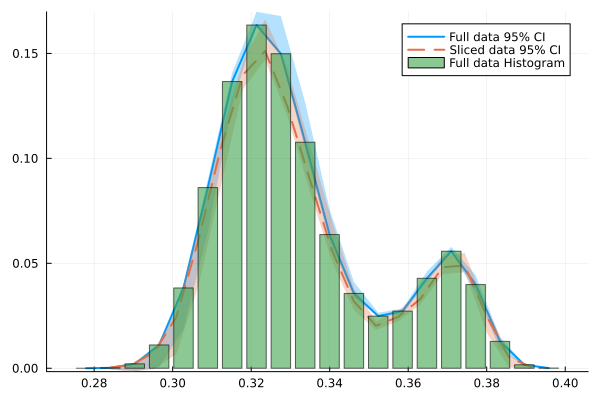

In [10]:
kstate = 2
data = distance_k[kstate]
slice_indeces = slice_indices = 1:50:length(data)
compare_histograms(data, slice_indices, num_bins=20, num_bootstrap=1000, confidence_level=0.95)